# Курсовой проект

Разведочный анализ данных на датасете "Страховые выплаты автомобилистам"

**Задачи проекта:**
1. Анализ данных датасета
2. Дисперсионный анализ зависимости страховых выплат от группы дохода
3. Корреляционная матрица

**Подключение библиотек и скриптов**

In [1]:
import math
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score as r2

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

**Путь к файлам**

In [2]:
DATASET_PATH = './insurance.csv'

**Описание датасета**

Статистические данные об обращениях в страховую компанию

* **Id** - идентификационный номер страхователя
* **Age** - возрастная группа
* **Gender** - пол
* **Race** - расовая принадлежность
* **Driving_experience** - стаж вождения
* **Education** - образование
* **Income** - уровень дохода
* **Credit_score** - кредитная оценка
* **Vehicle_ownership** - владелец транспорта
* **Vehicle_year** - год выпуска
* **Married** - семейное положение
* **Children** - дети
* **Postal_code** - индекс
* **Annual_mileage** - ежегодный пробег
* **Vehicle_type** - тип транспорта
* **Speeding_violations** - нарушения скорости
* **DUIS** - вождение в нетрезвом виде
* **Past_accidents** - предыдущие ДТП
* **Outcome** - обращение в страховую компанию (целевая переменная)

## 1. Анализ данных

In [3]:
df = pd.read_csv(DATASET_PATH, sep=',')
df['ID'] = df['ID'].astype(str)
df['POSTAL_CODE'] = df['POSTAL_CODE'].astype(str)
df["AGE"].replace({"16-25": "Young", "26-39": "Middle Age","40-64":"Old","65+":"Very Old"}, inplace=True)
df["DRIVING_EXPERIENCE"].replace({"0-9y": "Newbie", "10-19y": "Amateur","20-29y":"Advanced","30y+":"Expert"}, inplace=True)
df.head(10)

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,Very Old,female,majority,Newbie,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,Young,male,majority,Newbie,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,Young,female,majority,Newbie,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,Young,male,majority,Newbie,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,Middle Age,male,majority,Amateur,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0
5,877557,Old,female,majority,Advanced,high school,upper class,0.619127,1.0,after 2015,0.0,1.0,10238,13000.0,sedan,3,0,3,0.0
6,930134,Very Old,male,majority,Expert,high school,upper class,0.492944,0.0,after 2015,1.0,1.0,10238,13000.0,sedan,7,0,3,0.0
7,461006,Middle Age,female,majority,Newbie,university,working class,0.468689,0.0,after 2015,0.0,1.0,10238,14000.0,sedan,0,0,0,1.0
8,68366,Old,female,majority,Advanced,university,working class,0.521815,0.0,before 2015,1.0,0.0,10238,13000.0,sedan,0,0,0,0.0
9,445911,Old,female,majority,Newbie,high school,upper class,0.561531,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,1.0


In [4]:
df.shape

(10000, 19)

Распределение целевой переменной:

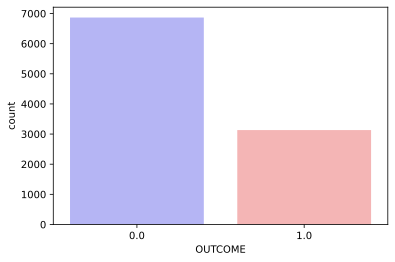

In [5]:
sns.countplot(x="OUTCOME", data=df, palette="bwr")
plt.show()

In [6]:
df.dtypes

ID                      object
AGE                     object
GENDER                  object
RACE                    object
DRIVING_EXPERIENCE      object
EDUCATION               object
INCOME                  object
CREDIT_SCORE           float64
VEHICLE_OWNERSHIP      float64
VEHICLE_YEAR            object
MARRIED                float64
CHILDREN               float64
POSTAL_CODE             object
ANNUAL_MILEAGE         float64
VEHICLE_TYPE            object
SPEEDING_VIOLATIONS      int64
DUIS                     int64
PAST_ACCIDENTS           int64
OUTCOME                float64
dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  object 
 1   AGE                  10000 non-null  object 
 2   GENDER               10000 non-null  object 
 3   RACE                 10000 non-null  object 
 4   DRIVING_EXPERIENCE   10000 non-null  object 
 5   EDUCATION            10000 non-null  object 
 6   INCOME               10000 non-null  object 
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  object 
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  object 
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  object 
 15  SPEEDING_VIOLATIONS  10000 non-null  

In [8]:
df.describe()

,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
count,9018.000000,10000.000000,10000.000000,10000.000000,9043.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,0.515813,0.697000,0.498200,0.688800,11697.003207,1.482900,0.23920,1.056300,0.313300
std,0.137688,0.459578,0.500022,0.463008,2818.434528,2.241966,0.55499,1.652454,0.463858
min,0.053358,0.000000,0.000000,0.000000,2000.000000,0.000000,0.00000,0.000000,0.000000
25%,0.417191,0.000000,0.000000,0.000000,10000.000000,0.000000,0.00000,0.000000,0.000000
50%,0.525033,1.000000,0.000000,1.000000,12000.000000,0.000000,0.00000,0.000000,0.000000
75%,0.618312,1.000000,1.000000,1.000000,14000.000000,2.000000,0.00000,2.000000,1.000000
max,0.960819,1.000000,1.000000,1.000000,22000.000000,22.000000,6.00000,15.000000,1.000000


array([[<AxesSubplot:title={'center':'CREDIT_SCORE'}>,
        <AxesSubplot:title={'center':'VEHICLE_OWNERSHIP'}>,
        <AxesSubplot:title={'center':'MARRIED'}>],
       [<AxesSubplot:title={'center':'CHILDREN'}>,
        <AxesSubplot:title={'center':'ANNUAL_MILEAGE'}>,
        <AxesSubplot:title={'center':'SPEEDING_VIOLATIONS'}>],
       [<AxesSubplot:title={'center':'DUIS'}>,
        <AxesSubplot:title={'center':'PAST_ACCIDENTS'}>,
        <AxesSubplot:title={'center':'OUTCOME'}>]], dtype=object)

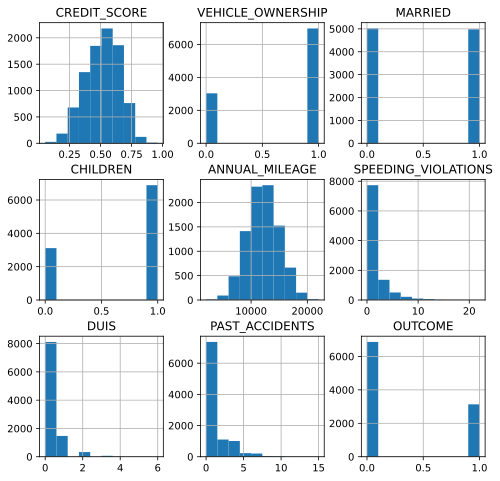

In [9]:
df.hist(figsize=(8,8))

**Заполнение пропусков**

Видим, что в данных присутствуют пропуски в полях CREDIT_SCORE и ANNUAL_MILEAGE.  
Заполним пропуски в поле ANNUAL_MILEAGE медианными значениями данной переменной.

In [10]:
median = df['ANNUAL_MILEAGE'].median()
df['ANNUAL_MILEAGE'][df['ANNUAL_MILEAGE'].isna()] = median
df['ANNUAL_MILEAGE'].isna().sum()

0

Для заполнения пропусков в поле CREDIT_SCORE проверим гипотезу, что кредитный рейтинг зависит от дохода.

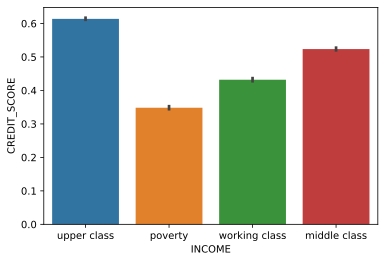

In [11]:
sns.barplot(x=df['INCOME'], y=df['CREDIT_SCORE']);
plt.show()

In [12]:
med_score_by_income = df.groupby(['INCOME'], as_index=False).agg({'CREDIT_SCORE':'median'})\
                            .rename(columns={'CREDIT_SCORE':'MED_SCORE'})
med_score_by_income

,INCOME,MED_SCORE
0,middle class,0.526747
1,poverty,0.349915
2,upper class,0.616289
3,working class,0.431376


In [13]:
df = df.merge(med_score_by_income, on=['INCOME'], how='left')
df['CREDIT_SCORE'][df['CREDIT_SCORE'].isna()] = df['MED_SCORE']
df.drop(columns='MED_SCORE', inplace=True)
df['CREDIT_SCORE'].isna().sum()

0

## 2. Дисперсионный анализ зависимости выплат от группы дохода

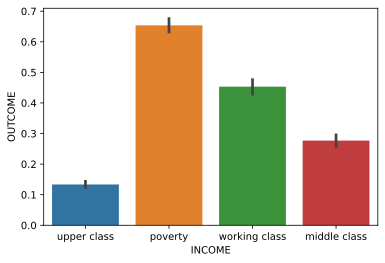

In [14]:
sns.barplot(x=df['INCOME'], y=df['OUTCOME']);
plt.show()

Проверим гипотезу, что обращение за страховыми выплатами связано с уровнем дохода - люди с низким уровнем дохода чаще обращаются за выплатами.

In [15]:
df2 = df.groupby(['INCOME'], as_index=False).agg({'OUTCOME':'mean'})\
                            .rename(columns={'OUTCOME':'MEAN'})
income_size = df['INCOME'].value_counts().reset_index()\
                    .rename(columns={'index':'INCOME', 'INCOME':'SIZE'})
df2 = df2.merge(income_size, on='INCOME', how='left')
df2

,INCOME,MEAN,SIZE
0,middle class,0.276894,2138
1,poverty,0.653804,1814
2,upper class,0.133533,4336
3,working class,0.453271,1712


In [16]:
y_mean = df['OUTCOME'].mean()
y_mean

0.3133

In [17]:
S2_F = 0
S2_res = 0
for col in df2['INCOME']:
    mean = df2.loc[df2['INCOME'] == col, 'MEAN'].values[0]
    size = df2.loc[df2['INCOME'] == col, 'SIZE'].values[0]
    S2_F += (size * (mean - y_mean) ** 2)
    S2_res += ((df['OUTCOME'][df['INCOME'] == col] - mean) ** 2).sum()
print(S2_F, S2_res)

386.81781429440423 1764.6132857055957


In [18]:
S2 = 0
S2 = ((df['OUTCOME'] - y_mean) ** 2).sum()
S2

2151.4311

In [19]:
S2_F + S2_res == S2

True

In [20]:
S2_F + S2_res, S2

(2151.4311, 2151.4311)

In [21]:
df['INCOME'].count()

10000

Вычислим несмещенные оценки дисперсий:

In [22]:
k = df2['INCOME'].count()
n = df['INCOME'].count()

k1 = k - 1
k2 = n - k

alpha = 0.05

F_crit = stats.f.ppf(1 - alpha, k1, k2)

sigma_f = S2_F / k1
sigma_res = S2_res / k2

T = sigma_f / sigma_res
T, F_crit, T > F_crit

(730.4019343329304, 2.6057974276112974, True)

Видим, что значение $T > F_{crit}$, поэтому делаем вывод, что отличие уровня дохода является статистически значимым.

## 3. Матрица корреляций

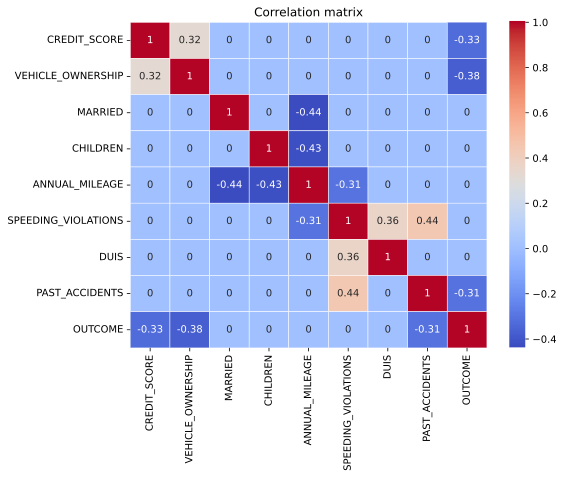

In [23]:
df_corr = df.corr()
df_corr = np.round(df_corr, 4)
df_corr[np.abs(df_corr) < 0.3] = 0
plt.figure(figsize = (8, 6))
sns.heatmap(df_corr, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

Видим, что между некоторыми признаками есть слабая коррлеяция - превышение скорости, вождение в нетрезвом виде, предыдущие ДТП. Есть обратная корреляция между кредитной оценкой, ТС в собственности и предыдущих ДТП с целевой переменной.

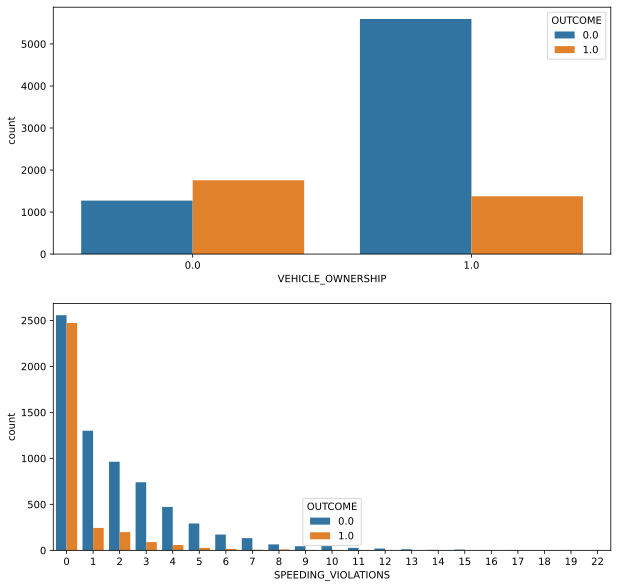

In [49]:
import warnings
warnings.filterwarnings("ignore")
fig,axes = plt.subplots(2,1,figsize=(10,10))
j=0

sns.countplot(data=df, x=df['VEHICLE_OWNERSHIP'],ax=axes[j],hue='OUTCOME');j+=1
sns.countplot(data=df, x=df['SPEEDING_VIOLATIONS'],ax=axes[j],hue='OUTCOME');j+=1

# import seaborn as sns
# for i in df.drop(['ID','CREDIT_SCORE','ANNUAL_MILEAGE','OUTCOME'],axis=1).columns:
#     sns.countplot(data=df , x=i,ax=axes[j],hue='OUTCOME');j+=1